# README
## まとめ
- PublicScore: 0.7751

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('input/titanic/train.csv', usecols=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'])
test = pd.read_csv('input/titanic/test.csv', usecols=['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'])

# 前処理

In [3]:
X_train = train.drop(columns=['Survived']).copy()
y_train = train['Survived']

X_test = test.copy()

# Sex
# 文字列を数値に変換(LabelEncodingと呼ぶ)
sex_dict = {'male': 1, 'female': 0}
X_train['Sex'] = X_train['Sex'].map(sex_dict)
X_test['Sex'] = X_test['Sex'].map(sex_dict)

# Embarked
# 欠損の件数が少なくカーディナリティも低いので最頻値で埋めておく
# 文字列を数値に変換(LabelEncoding)
X_train['Embarked'] = X_train['Embarked'].fillna('S')
embarked_dict = {'S': 0, 'C': 1, 'Q': 2}

X_train['Embarked'] = X_train['Embarked'].map(embarked_dict)
X_test['Embarked'] = X_test['Embarked'].map(embarked_dict)

# Fare
# 欠損が1件なので中央値で埋める
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())

# 確認
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,1,1,0,7.2500,0
1,1,0,1,0,71.2833,1
2,3,0,0,0,7.9250,0
3,1,0,1,0,53.1000,0
4,3,1,0,0,8.0500,0




# GridSearch & Pipeline
- 標準化 → GridSearch

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

skf = StratifiedKFold(n_splits=10, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression())])

param_grid = {'logreg__C': [10**x for x in range(-3, 5)]}

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=skf,
                    n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_, grid.best_score_)

{'logreg__C': 1} 0.7934904601571269


In [5]:
# 回帰係数もみておく
best_logreg = grid.best_estimator_.named_steps['logreg']

for c, i in zip(X_train.columns, best_logreg.coef_[0]):
    print(f'{i:.4f}{c} + ', end='')

print(f'{best_logreg.intercept_[0]:.4f}')

-0.7151Pclass + -1.2848Sex + -0.2573SibSp + -0.0525Parch + 0.1430Fare + 0.1461Embarked + -0.6251


# SubmissonFile の作成


In [6]:
submit_data = pd.read_csv('input/titanic/gender_submission.csv')
submit_data['Survived'] = grid.predict(X_test)

# かなり雑だが、使用したカラムをファイル名につけておく
suffix = '_'.join(X_train.columns)
submit_data.to_csv(f'submission/logreg_標準化_{suffix}.csv', index=False)

# 木モデルを使って重要度を見る

In [7]:
def visualize_feature_importance(model, X_train):
    # barplotに持ち込むためのDFを生成
    df = pd.DataFrame()
    df['feature_name'] = X_train.columns
    df['feature_importance'] = model.feature_importances_

    # 降順のほうが見やすいのでソート
    df.sort_values(by='feature_importance', ascending=False, inplace=True)

    # 重要度0はノイズに思えるので除外している
    df = df[df['feature_importance'] > 0]

    sns.barplot(x='feature_importance',
                y='feature_name',
                data=df)

    plt.xlim(0, 1.0)

{'max_depth': 8} 0.8148148148148148


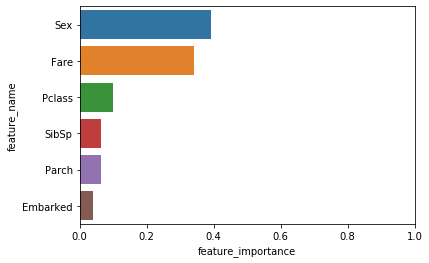

In [8]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'max_depth': [x for x in range(2, 10)]}

grid_rf = GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid=param_grid_rf,
                    scoring='accuracy',
                    cv=skf,
                    n_jobs=-1)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_, grid_rf.best_score_)

visualize_feature_importance(grid_rf.best_estimator_, X_train)

おわり